# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix CHANGE
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 12, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html CHANGE
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=42)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 9402, 'TN': 110666, 'FP': 4009, 'FN': 3579, 'Accuracy': 0.9405590023187316, 'Precision': 0.7010662888673477, 'Recall': 0.7242893459671828, 'desc': 'ols_train'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 8849, 'TN': 112380, 'FP': 2295, 'FN': 4132, 'Accuracy': 0.9496537569718618, 'Precision': 0.794059583632448, 'Recall': 0.6816886218319081, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 8721, 'TN': 112382, 'FP': 2293, 'FN': 4260, 'Accuracy': 0.948666729335088, 'Precision': 0.7918104230978754, 'Recall': 0.6718280563901087, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 10766, 'TN': 99035, 'FP': 15640, 'FN': 2215, 'Accuracy': 0.8601319170270101, 'Precision': 0.4077103688555631, 'Recall': 0.8293659964563593, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 8702, 'TN': 111952, 'FP': 2723, 'FN': 4279, 'Accuracy': 0.9451494641849972, 'Precision': 0.7616630196936542, 'Recall': 0.6703643787073414, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 5921, 'TN': 114260, 'FP': 415, 'FN': 7060, 'Accuracy': 0.9414441937707589, 'Precision': 0.9345012626262627, 'Recall': 0.4561281873507434, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12981, 'Neg': 114675, 'TP': 0, 'TN': 114675, 'FP': 0, 'FN': 12981, 'Accuracy': 0.8983126527542771, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/sarahlee/Downloads/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

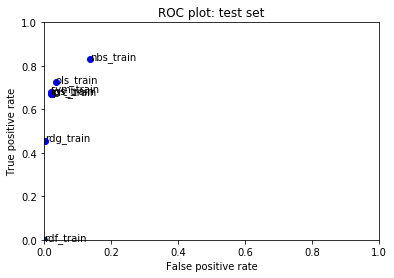

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
3033
Flewis likes gerbiling
* * * * * * * * * 
4741
I hope all goes well with the birth - congratulations!
* * * * * * * * * 
5063
"
The way that they said that makes think that there will be future sequals...  S.L.J.C.O.A.A.A.T.R. "
* * * * * * * * * 
5090
Are you there? This needs your URGENT attention Sue Anne. Cmon, surely you should ACT atleast this time.

Hi,

Are you there Sue Anne? This needs your urgent attention.

Apropos my earlier message to you, I removed the pathetic PA from Royboycrashfan 's talk page and warned Crossmr against the PA along with a fair note. Please do read that note.

But he removed my first warning and also reverted back the pathetic PA comment on roy's user page ALONG WITH pathetic PA's AGAIN, in both edit summaries.

I gave him a final warning as he repeatedly violated NPA and would not cease and desist.

Yet he continued with his same unacceptable behaviour.

The edit histories of the talk pages of User_talk:Royboycrashfa

22227
Complaint 

Acroterion, I wrote a letter complaining about you to Wikipedia corporate. You will be held accountable for your behavior.
* * * * * * * * * 
23487
You must be logged in to upload files. 

So In other words I have to sign up just to add 3 things to 1 entry.

To hell with that!!!!! This place can ROT for all I care!!!

75.8.35.177
* * * * * * * * * 
23680
"

 (//c) lightly smacks Wafulz with a minnow. P You rouge admin, you.  (//c) "
* * * * * * * * * 
23949
He's my grandad. Cool? I think so.
* * * * * * * * * 
23968
You should not have indefinitely blocked  I am not a troll.
* * * * * * * * * 
23981
All your base are belong to us
* * * * * * * * * 
24151
x factor 

Excuse me but why are you removing my content on x factor ? You have no right !
* * * * * * * * * 
24192
"

 Bulgars 

omg!! you are an admin and you protect the people who vandalise the ""Bulgars"" article. these attackers are pan-slavic ultra-nationalists and they dont want to see the word beginning with 

34329
hua 

You Can't Deny Me! Shea! Balla!
* * * * * * * * * 
34504
You obviously do not understand. KLA was not a governmental organization. Serb police or army was. Whatever KLA was doing, police and army must conduct their operations in accordance with law. Mass shooting of alleged KLA members without investigation and trial was clearly NOT in accordance with law.
* * * * * * * * * 
34547
"

 requesting your thought 

Talk:Karen Gillan ""Lady Godiva incident"" I would like for you to weigh in on whether or not it should be added. Thanks   "
* * * * * * * * * 
34608
For the record, that statement is downright depressing, Niemti. WP:VG/RS's promotion of Polish RSes dwarfs its promotion of any other non-English source. Seems like I wasted my time if even those who would use Polish sources deny their very existence at WP:VG/RS. Oh well... -
* * * * * * * * * 
34851
A section on polychromy should be added.
* * * * * * * * * 
35173
We quote what the police have said, not what you want th

73027
the Coolac geo site,
* * * * * * * * * 
73667
You mean my past BLOCK. The third block was because of your incompetence. Jesus doesn't like liars.
* * * * * * * * * 
73670
you deleted 2 times.. net is three and your out -
* * * * * * * * * 
76232
|ESC Region 11 - White Settlement, Texas
* * * * * * * * * 
76517
Horace Mann School 

Stay off the horace mann page...
* * * * * * * * * 
76808
You don't like her???
* * * * * * * * * 
76844
unnecessary and unwanted
* * * * * * * * * 
77808
To Dawnseeker2000 

 please explain the action of you revert Taiwan part
If you keeping act rude without reason I see you in the Village pump
* * * * * * * * * 
78984
if your gonna keep reverting my edit then you just don't belive me do you?
if you don't belive me then how come he has'nt edited for a very long time? his last edit was in April 2006
by the way i am not trying to vandalise the page ok? 82.33.160.8
* * * * * * * * * 
80972
Are you that scared? )
* * * * * * * * * 
81492
I was blocked for 

104495
I don't use myspace, i have a philosophical problem with that site... but i understand what it is about... but still, i feel like an idiot now.. *Hangs head in shame*
* * * * * * * * * 
104793
"Isn't it amazing that when your aren't judge jury and executioner you are proven wrong?  Blog all you like, no one is afraid of you because we all know how bias you are.  Its called ""censorship"" when i take something off, but when you do its because I ""dont get to"" quote something that proves you wrong.  

I would put the press release in but thats not relevant!! X )     

"
* * * * * * * * * 
104898
I never agreed not to edit outside my userspace. I agreed not to TEST outside my userspace.
* * * * * * * * * 
105542
, except that he is one of your friends
* * * * * * * * * 
105640
"

 Some falafel for you! 

     "
* * * * * * * * * 
105647
i hate k6ka 

he took down what i had put up and thinks he is the boss but he is not and should really put my content back up!!!!!!!!!
* * * * * *

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2182, 'TN': 27115, 'FP': 1556, 'FN': 1062, 'Accuracy': 0.9179696067679775, 'Precision': 0.5837346174424826, 'Recall': 0.6726263871763255, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 1996, 'TN': 27818, 'FP': 853, 'FN': 1248, 'Accuracy': 0.934168886103713, 'Precision': 0.7005967005967007, 'Recall': 0.6152897657213316, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 1979, 'TN': 27860, 'FP': 811, 'FN': 1265, 'Accuracy': 0.9349522168259439, 'Precision': 0.7093189964157706, 'Recall': 0.6100493218249076, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2557, 'TN': 24632, 'FP': 4039, 'FN': 687, 'Accuracy': 0.8519191602694658, 'Precision': 0.38765918738629473, 'Recall': 0.7882244143033292, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 1984, 'TN': 27699, 'FP': 972, 'FN': 1260, 'Accuracy': 0.9300642331192229, 'Precision': 0.6711772665764547, 'Recall': 0.6115906288532675, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 1414, 'TN': 28563, 'FP': 108, 'FN': 1830, 'Accuracy': 0.9392762024126586, 'Precision': 0.9290407358738502, 'Recall': 0.4358816276202219, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 0, 'TN': 28671, 'FP': 0, 'FN': 3244, 'Accuracy': 0.898355005483315, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

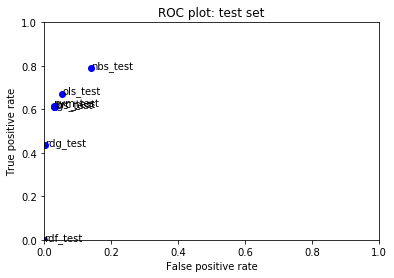

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [29]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=42, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 4096)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6         

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [30]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = nbs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.29060353607897416


In [31]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [32]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [33]:
my_submission.shape

(153164, 2)

In [34]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation